# README

We are going to show the frequency that values of TI are selected as the most monoexponential out of a range of TI values typically used for an IR experiment. We show this for a single value of SNR and then for a range of SNR values.

# Libraries

In [29]:
#Preparing all libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import minimize
# import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import colorsys
from datetime import date
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

# Options

In [30]:
intEnds = True           #bases TI values around integer values

# Initialization

In [31]:
######All Fixed parameters for code
#Parameters held constant
c1 = 0.4
c2 = 0.6 #0.5
T21 = 40
T22 = 100
T11 = 600
T12 = 1200

true_params = np.array([T11, T12, c1, c2, T21, T22])

multi_starts_BIC = 3

#Preparing TI array to loop through
TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

nTE = 64
dTE = 8
TE_DATA = np.linspace(dTE, dTE*nTE, nTE) #ms units
assert(TE_DATA[-1] == dTE*nTE)

SNR_value = 100

SNR_array = np.logspace(1, 5, 17)

repetition = 100

#Preparing TI array to loop through
TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

T12 = 1200
TI_DATA = np.append(0,np.logspace(1,np.log10(3*T12),11))//1

ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']

# Theoretical RSS coefficients
R0_coeff_TI1 = (c1**2 * T21 *(T21 - T22)**4)/(2*T11**2 * (T21 + T22)**4)
R0_coeff_TI2 = (c2**2 * T22 *(T21 - T22)**4)/(2*T12**2 * (T21 + T22)**4)

# Functions

In [32]:
#Defining the function of interest

def S_biX_6p(TE, T11, T12, c1, c2, T21, T22, TI = 0):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

#All curves get noise according to this equation
def add_noise(data, SNR):
    #returns a noised vector of data using the SNR given
    sigma = (c1+c2)/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    noised_data = data + noise
    return noised_data

#The one dimensional models are used to evaluate if a curve is more likely monoX or biX
def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

In [33]:
def BIC_calc(RSS, TE_array, p_list, sigma):

    BIC = 1/len(TE_array) * (RSS + np.log(len(TE_array))*len(p_list)*(sigma)**2)

    return BIC

def BIC_int_lengh_calc(R0, num_TE, diff_TE, SNR):
    return ((2*np.log(num_TE)-2)*diff_TE/(R0*SNR**2))**(1/2)


def get_func_bounds(func):
    f_name = func.__name__
    if f_name == "S_biX_6p":
        lower_bound = (2, 2, 0, 0, 2, 2)
        upper_bound = (2000, 2000, 1, 1, 150, 150)
    elif f_name == "S_moX_3p":
        lower_bound = (2, 0, 2)
        upper_bound = (2000, 1, 150)
    elif f_name == "S_biX_4p":
        lower_bound = (-1, -1, 2, 2)
        upper_bound = (1, 1, 150, 150)
    elif f_name == "S_moX_2p":
        lower_bound = (-1, 2)
        upper_bound = (1, 150)
    else:
        raise Exception("Not a valid function: " + f_name)

    return lower_bound, upper_bound

def set_p0(func, random = True):
    true_params = [T11, T12, c1, c2, T21, T22]
    if random:
        lb, ub = get_func_bounds(func)
        if func.__name__.find("S_biX_6p") > -1:
            T11_est = np.random.uniform(lb[-6],ub[-6])
            T12_est = np.random.uniform(T11_est,ub[-5])
            c1_est = np.random.uniform(lb[-4],ub[-4])
            T21_est = np.random.uniform(lb[-2],ub[-2])
            T22_est = np.random.uniform(T21_est,ub[-1])
            p0 = [T11_est, T12_est, c1_est, 1-c1_est, T21_est, T22_est]
        else:
            p0 = [np.random.uniform(lb[i],ub[i]) for i in range(len(lb))]
    else:
        # f_name = func.__name__
        # if f_name.find("moX") > -1:
        #     p0 = [75, 0.5, 75]
        # elif f_name.find("biX") > -1:
        #     p0 = [75, 75, 0.5, 0.5, 75, 75]
        # else:
        p0 = true_params
            
    return p0

def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def calculate_RSS(func, popt, data):
    est_curve = func(TE_DATA, *popt)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def estP_oneCurve(func, noisey_data):

    init_p = set_p0(func, random = True)
    lb, ub = get_func_bounds(func)

    popt, _ = curve_fit(func, TE_DATA, noisey_data, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
    popt = check_param_order(popt)
    RSS = calculate_RSS(func, popt, noisey_data)

    return popt, RSS

def evaluate_model(data, SNR, ms_iter = multi_starts_BIC):

    #Returns true if the moX is better than the biX --> returns a 1 for moX and a 0 for biX
    #Returns the parameters of the correct answer

    RSS_biX = np.inf
    RSS_moX = np.inf

    for ms in range(ms_iter):
        popt_biX_temp, RSS_biX_temp = estP_oneCurve(S_biX_4p, data)
        popt_moX_temp, RSS_moX_temp = estP_oneCurve(S_moX_2p, data)

        if RSS_biX_temp < RSS_biX:
            popt_biX = popt_biX_temp
            RSS_biX = RSS_biX_temp

        if RSS_moX_temp < RSS_moX:
            popt_moX = popt_moX_temp
            RSS_moX = RSS_moX_temp

    # popt_biX, RSS_biX = estP_oneCurve(S_biX_4p, data)
    # popt_moX, RSS_moX = estP_oneCurve(S_moX_2p, data)

    BIC_biX = BIC_calc(RSS_biX, TE_DATA, popt_biX, 1/SNR)
    BIC_moX = BIC_calc(RSS_moX, TE_DATA, popt_moX, 1/SNR)

    BIC_diff = BIC_biX - BIC_moX    #the more positive this is, the better

    if BIC_moX < BIC_biX:
        return True, popt_moX, RSS_moX, BIC_diff
    else:
        return False, popt_biX, RSS_biX, BIC_diff

# Generating Data

In [34]:
all_data = np.zeros((TI_DATA.shape[0], TE_DATA.shape[0]))

for iTI in range(TI_DATA.shape[0]):
    all_data[iTI,:] = S_biX_6p(TE_DATA, *true_params, TI = TI_DATA[iTI])

# noised_data = add_noise(all_data, SNR_value)

In [35]:
freq_array = np.zeros(TI_DATA.shape[0])

for rep in trange(repetition):
    temp_BIC = np.zeros(TI_DATA.shape[0])
    for iTI in range(TI_DATA.shape[0]):
        noisy_curve = add_noise(all_data[iTI, :], SNR_value)
        _, _, _, temp_BIC[iTI] = evaluate_model(noisy_curve, SNR_value)

    temp_index = scipy.signal.find_peaks(temp_BIC, height = 0, distance = 2)

    if len(temp_index[0])>0:
        for iT in temp_index[0]:
            freq_array[iT] = freq_array[iT] + 1

freq_array = freq_array/repetition

100%|██████████| 100/100 [00:46<00:00,  2.17it/s]


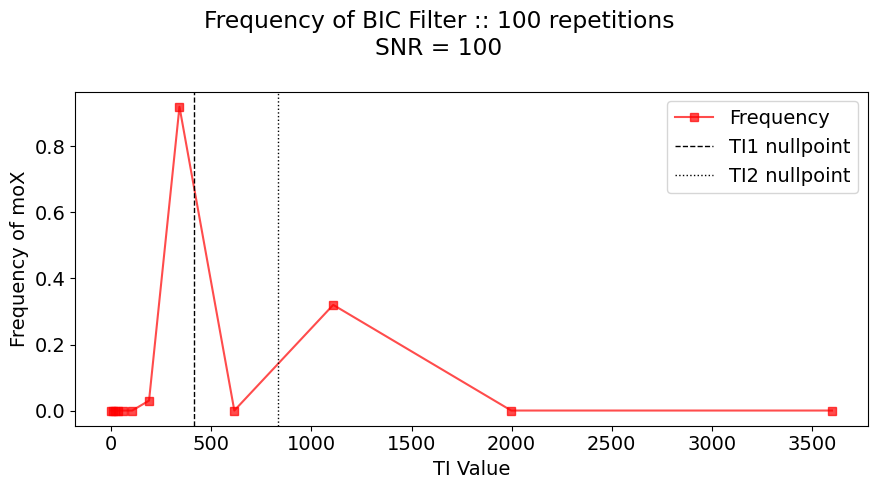

In [36]:
plt.rc('font', size = 14)
fig, ax = plt.subplots(1,1, figsize=(9,5), tight_layout=True)
fig.suptitle(f'Frequency of BIC Filter :: {repetition} repetitions\nSNR = {SNR_value}')


ax.plot(TI_DATA, freq_array, alpha = 0.7, color = 'r', label = 'Frequency', marker = 's')

ax.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k', ls = '--')
ax.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = ':')

ax.set_xlabel('TI Value')
ax.set_ylabel('Frequency of moX')
# ax.set_title('TI1 nullpoint')
ax.legend()

plt.show()

# SNR vs. TI Array

In [51]:
freq_array_2D = np.zeros((TI_DATA.shape[0], SNR_array.shape[0]))

for iSNR in range(SNR_array.shape[0]):
    SNR_temp = SNR_array[iSNR]
    
    for rep in trange(repetition):
        temp_BIC = np.zeros(TI_DATA.shape[0])
        for iTI in range(TI_DATA.shape[0]):
            noisy_curve = add_noise(all_data[iTI, :], SNR_temp)
            _, _, _, temp_BIC[iTI] = evaluate_model(noisy_curve, SNR_temp)

        temp_index = scipy.signal.find_peaks(temp_BIC, height = 0, distance = 2)

        if len(temp_index[0])>0:
            for iT in temp_index[0]:
                freq_array_2D[iT, iSNR] = freq_array_2D[iT, iSNR] + 1
    

    print(f"Finished {SNR_array[iSNR]} :: Completed {iSNR+1} SNR values of {SNR_array.shape[0]}")

freq_array_2D = freq_array_2D/repetition

100%|██████████| 100/100 [00:44<00:00,  2.25it/s]


Finished 10.0 :: Completed 1 SNR values of 17


100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Finished 17.78279410038923 :: Completed 2 SNR values of 17


100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


Finished 31.622776601683796 :: Completed 3 SNR values of 17


100%|██████████| 100/100 [00:46<00:00,  2.15it/s]


Finished 56.23413251903491 :: Completed 4 SNR values of 17


100%|██████████| 100/100 [00:43<00:00,  2.28it/s]


Finished 100.0 :: Completed 5 SNR values of 17


100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


Finished 177.82794100389228 :: Completed 6 SNR values of 17


100%|██████████| 100/100 [00:39<00:00,  2.52it/s]


Finished 316.2277660168379 :: Completed 7 SNR values of 17


100%|██████████| 100/100 [00:37<00:00,  2.63it/s]


Finished 562.341325190349 :: Completed 8 SNR values of 17


100%|██████████| 100/100 [00:37<00:00,  2.66it/s]


Finished 1000.0 :: Completed 9 SNR values of 17


100%|██████████| 100/100 [00:37<00:00,  2.66it/s]


Finished 1778.2794100389226 :: Completed 10 SNR values of 17


100%|██████████| 100/100 [00:37<00:00,  2.68it/s]


Finished 3162.277660168379 :: Completed 11 SNR values of 17


100%|██████████| 100/100 [00:37<00:00,  2.66it/s]


Finished 5623.41325190349 :: Completed 12 SNR values of 17


100%|██████████| 100/100 [00:37<00:00,  2.65it/s]


Finished 10000.0 :: Completed 13 SNR values of 17


100%|██████████| 100/100 [00:37<00:00,  2.67it/s]


Finished 17782.794100389227 :: Completed 14 SNR values of 17


100%|██████████| 100/100 [00:37<00:00,  2.67it/s]


Finished 31622.776601683796 :: Completed 15 SNR values of 17


100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


Finished 56234.1325190349 :: Completed 16 SNR values of 17


100%|██████████| 100/100 [00:37<00:00,  2.68it/s]

Finished 100000.0 :: Completed 17 SNR values of 17


In [52]:
mSNR, mTI = np.meshgrid(SNR_array, TI_DATA)

print(f"Shape of TI Data = {TI_DATA.shape} and shape of SNR_array = {SNR_array.shape}")
print(f"mesh shape = {mTI.shape}")
print(f"First value in TI mesh = {mTI[0,0]}")

Shape of TI Data = (12,) and shape of SNR_array = (17,)
mesh shape = (12, 17)
First value in TI mesh = 0.0


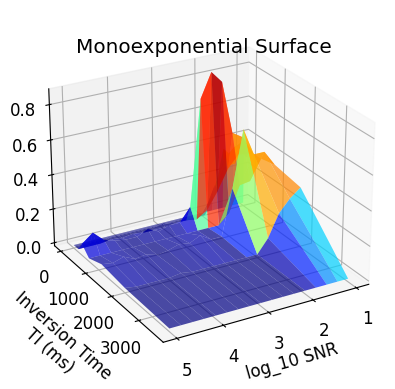

In [53]:


fig = plt.figure(figsize = (6,4), tight_layout=True)
plt.rc('font', size = 12)
ax = plt.axes(projection='3d')
# my_col = cm.jet(sig/np.amax(sig))
ax.plot_surface(np.log10(mSNR) , mTI, freq_array_2D, alpha = 0.7, cmap = cm.jet)
ax.view_init(25,60)
# ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 12
# ax.zaxis.labelpad = 9

ax.set_ylabel('Inversion Time\nTI (ms)')
ax.set_xlabel('log_10 SNR')
# ax.set_zlabel('Signal')
ax.set_title('Monoexponential Surface', y=1.0, pad=-10)
# ax.dist = 12

plt.show()

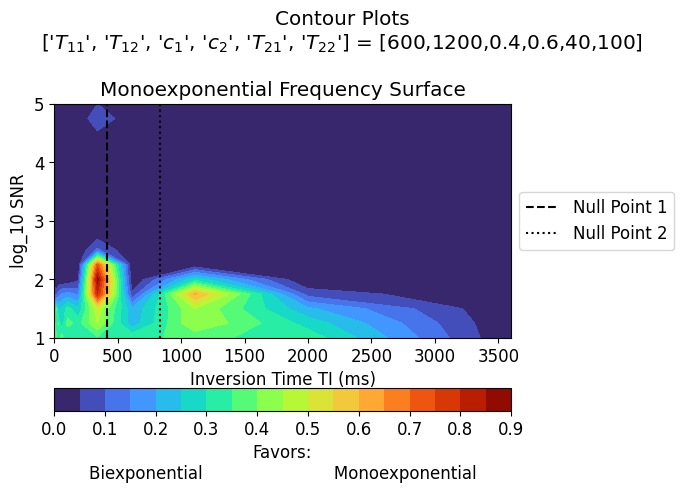

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(7,5), tight_layout=True)
fig.suptitle(f"Contour Plots\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")

cp = ax.contourf( np.matrix.transpose(mTI), np.matrix.transpose(np.log10(mSNR)), np.matrix.transpose(freq_array_2D), 20, cmap = 'turbo')
ax.axvline(x=TI1star, color = 'k', ls = '--', label = 'Null Point 1')
ax.axvline(x=TI2star, color = 'k', ls = ':', label = 'Null Point 2')

ax.set_xlabel('Inversion Time TI (ms)')
ax.set_ylabel('log_10 SNR')
ax.set_title('Monoexponential Frequency Surface')
fig.colorbar(cp, ax = ax, location = 'bottom', label = "Favors:\nBiexponential                         Monoexponential")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [1]:
SNR_oi = 0

plt.rc('font', size = 14)
fig, ax = plt.subplots(1,1, figsize=(9,5), tight_layout=True)
fig.suptitle(f'Frequency of BIC Filter :: {repetition} repetitions\nSNR = {SNR_array[SNR_oi]}')

ax.plot(TI_DATA, freq_array_2D[:,SNR_oi], alpha = 0.7, color = 'r', label = 'Frequency', marker = 's')

ax.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k', ls = '--')
ax.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = ':')

ax.set_xlabel('TI Value')
ax.set_ylabel('Frequency of moX')
# ax.set_title('TI1 nullpoint')
ax.legend()

plt.show()

NameError: name 'plt' is not defined

In [56]:
moX_reg_T1 = BIC_int_lengh_calc(R0_coeff_TI1, nTE, dTE, SNR_array)
moX_reg_T1_low = TI1star - moX_reg_T1
moX_reg_T1_high = TI1star + moX_reg_T1

moX_reg_T2 = BIC_int_lengh_calc(R0_coeff_TI2, nTE, dTE, SNR_array)
moX_reg_T2_low = TI2star - moX_reg_T2
moX_reg_T2_high = TI2star + moX_reg_T2

cross_index = np.where(moX_reg_T1_high<moX_reg_T2_low)[0][0]
# print(cross_index)

x_array = np.concatenate((moX_reg_T1_low, np.flip(moX_reg_T1_high), moX_reg_T2_low, np.flip(moX_reg_T2_high)))
y_array = np.concatenate((SNR_array, np.flip(SNR_array), SNR_array, np.flip(SNR_array)))

# x_array = np.concatenate((moX_reg_T1_low, np.flip(moX_reg_T1_high[(cross_index-1):]), moX_reg_T2_low[cross_index:], np.flip(moX_reg_T2_high)))
# y_array = np.concatenate((SNR_array, np.flip(SNR_array[(cross_index-1):]), SNR_array[cross_index:], np.flip(SNR_array)))

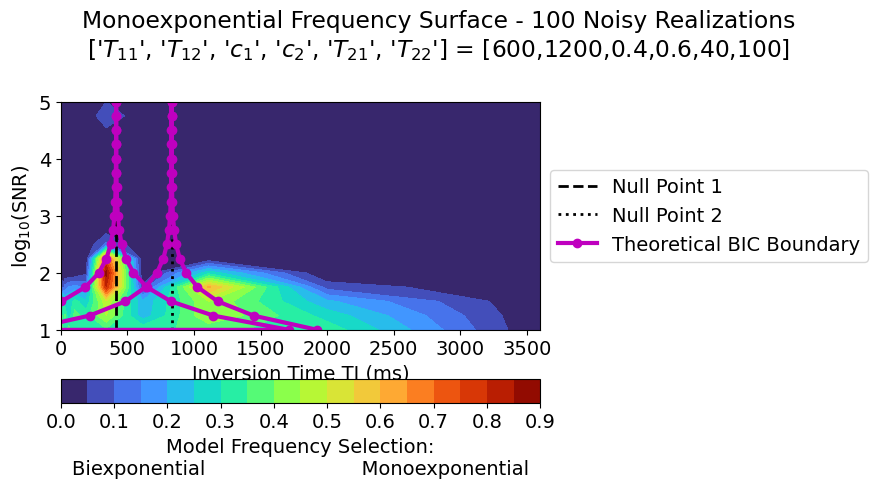

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(9,5), tight_layout=True)
fig.suptitle(f"Monoexponential Frequency Surface - {repetition} Noisy Realizations\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T22}]")

cp = ax.contourf( np.matrix.transpose(mTI), np.matrix.transpose(np.log10(mSNR)), np.matrix.transpose(freq_array_2D), 20, cmap = 'turbo')
ax.axvline(x=TI1star, color = 'k', ls = '--', label = 'Null Point 1', lw = 2)
ax.axvline(x=TI2star, color = 'k', ls = ':', label = 'Null Point 2', lw = 2)
ax.plot(x_array, np.log10(y_array), color =  'm', lw = 3, label = 'Theoretical BIC Boundary', marker = 'o')
ax.set_xlim([TI_DATA[0], TI_DATA[-1]])

ax.set_xlabel('Inversion Time TI (ms)')
ax.set_ylabel(r'log$_{10}$(SNR)')
# ax.set_title('')
fig.colorbar(cp, ax = ax, location = 'bottom', label = "Model Frequency Selection:\nBiexponential                         Monoexponential")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))